In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm

In [2]:
import pytorch_lightning as pl

In [3]:
label_list = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
    ]

In [5]:
import sys
sys.path.insert(0, '../')

In [6]:
from fashionist.constants import STORAGE_DIR

In [9]:
labels = np.frombuffer(
    STORAGE_DIR.joinpath('t10k-labels-idx1-ubyte').open('rb').read(), 
    dtype=np.uint8,
    offset=8,
)

images = np.frombuffer(
    STORAGE_DIR.joinpath('t10k-images-idx3-ubyte').open('rb').read(), 
    dtype=np.uint8,
    offset=16,
).reshape(len(labels), 784)

In [10]:
images.shape, labels.shape

((10000, 784), (10000,))

'Coat'

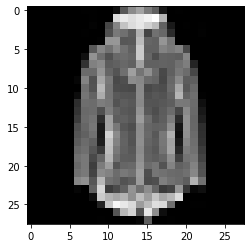

In [11]:
idx = np.random.randint(10000)
plt.imshow(images[idx].reshape(28, 28), cmap='gray')
label_list[labels[idx]]

In [17]:
class FashionDS(Dataset):
    index = None
    def __init__(self, train = True):
        self.imgs = images.copy()
        self.labels = labels.copy()
        self.label_lst = label_list
        self.train = train
        self.train_fraction = len(labels) * 8 // 10
        if FashionDS.index is None:
            FashionDS.index = np.random.permutation(np.arange(len(self.labels)))
        
    def __len__(self):
        if self.train:
            return self.train_fraction
        else:
            return len(self.labels) - self.train_fraction
    
    def __getitem__(self, idx):
        if self.train:
            idx2 = FashionDS.index[idx]
        else:
            idx2 = FashionDS.index[self.fraction + idx]
        return self.imgs[idx2].reshape(28, 28), self.labels[idx2]

8000


'Coat'

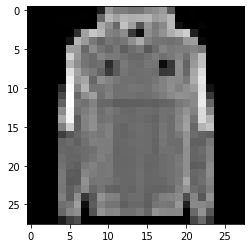

In [18]:
ds = FashionDS()
print(len(ds))
idx = np.random.randint(len(ds))
x, y = ds[idx]
plt.imshow(x, cmap='gray')
ds.label_lst[y]

2000


'Sneaker'

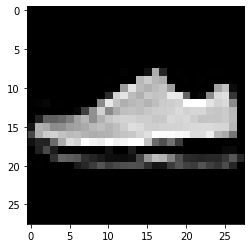

In [19]:
valds = FashionDS(False)
print(len(valds))
idx = np.random.randint(len(valds))
x, y = ds[idx]
plt.imshow(x, cmap='gray')
ds.label_lst[y]

In [20]:
dl = DataLoader(ds, batch_size=16, shuffle=True)

In [21]:
x, y = next(iter(dl))
x.shape, y.shape

(torch.Size([16, 28, 28]), torch.Size([16]))

model

In [57]:
class Net(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv = torch.nn.Conv2d(1, 5, 3)
        self.linear = torch.nn.Linear(26*26*5, 10)
        
    def forward(self, x):
        out = self.conv(x)
        out = torch.nn.functional.relu(out)
        out = out.view(-1, 26*26*5)
        out = self.linear(out)
        return out
    
    def training_step(self, batch, batch_id):                   
        x, y = batch
        x = x.float() / 255.
        yhat = self(x[:, None, ...])
        acc = (yhat.argmax(dim=1) == y).sum()*1.0 / len(y)
        loss = torch.nn.functional.cross_entropy(yhat, y.long())
        self.log('train loss', loss.item())                    
        self.log('train acc', acc)   
        return loss
    
    def configure_optimizers(self):
        self.lr = 3e-4
        opt = torch.optim.SGD(self.parameters(), self.lr, 0.9)
        sched = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[5, 10], gamma=0.1) 
        return {
            'optimizer': opt,                                                       
            'lr_scheduler': sched,
        }
    
    def train_dataloader(self):                     
        return DataLoader(FashionDS(), batch_size=64)

In [62]:
net = Net()
trainer = pl.Trainer(max_epochs = 15)         
trainer.fit(net)  

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type   | Params
----------------------------------
0 | conv   | Conv2d | 50    
1 | linear | Linear | 33.8 K
----------------------------------
33.9 K    Trainable params
0         Non-trainable params
33.9 K    Total params
0.135     Total estimated model params size (MB)


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████| 125/125 [00:01<00:00, 117.04it/s, loss=0.754, v_num=11]


In [53]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs